In [ ]:
from osgeo import gdal
import numpy as np

dem_file_path = "/content/D60624ne.pix"

In [ ]:
dem_dataset = gdal.Open(dem_file_path)
if dem_dataset is None:
    print("Could not open the DEM file.")
    exit()

dem_array = dem_dataset.GetRasterBand(1).ReadAsArray()

In [ ]:
def fill_algorithm(dem):
    # Get the dimensions of the DEM array
    rows, cols = dem.shape

    # Create a copy of the DEM array to store the filled values
    filled_dem = dem.copy()

    # Calculate border values
    border_values = [dem[0, :], dem[-1, :], dem[:, 0], dem[:, -1]]
    border_values = np.concatenate(border_values)
    border_values = border_values[~np.isnan(border_values)]

    # Fill NaN values with the mean of border values
    filled_dem[np.isnan(filled_dem)] = np.mean(border_values)

    # Fill algorithm
    changed = True  # Condition for changes in the array
    while changed:
        changed = False
        min_index = np.unravel_index(np.nanargmin(filled_dem), filled_dem.shape)
        min_value = filled_dem[min_index]

        # If there are no valid values left, break out of the loop
        if np.isnan(min_value):
            break

        # Define neighboring pixels
        neighbors = [(min_index[0] - 1, min_index[1]),
                     (min_index[0] + 1, min_index[1]),
                     (min_index[0], min_index[1] - 1),
                     (min_index[0], min_index[1] + 1)]

        # Iterate over neighboring pixels
        for neighbor in neighbors:
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                neighbor_value = filled_dem[neighbor]
                # Update neighbor value if it's NaN or greater than the minimum value
                if np.isnan(neighbor_value) or neighbor_value > min_value:
                    filled_dem[neighbor] = min_value
                    changed = True  # When a change is made, update the condition to True

    return filled_dem


In [ ]:
filled_dem_array = fill_algorithm(dem_array)

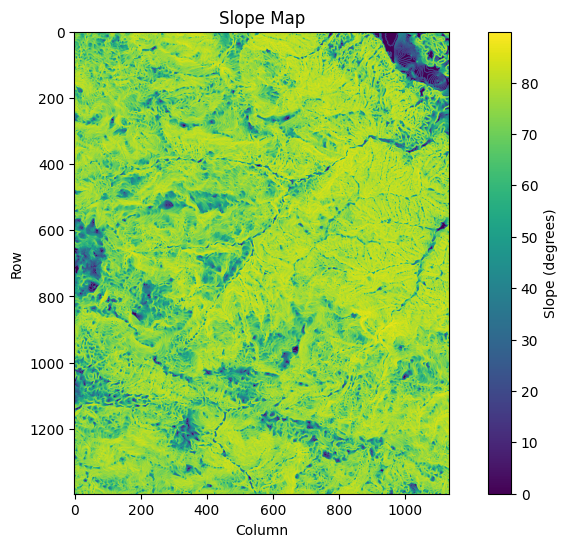

In [ ]:
import numpy as np

def calculate_slope(filled_dem, cell_size):
    # Calculate the vertical difference in elevation between neighboring cells
    dz_dy, dz_dx = np.gradient(filled_dem, cell_size, cell_size)

    # Calculate slope using the vertical difference
    slope_degrees = np.arctan(np.sqrt(dz_dx ** 2 + dz_dy ** 2)) * (180 / np.pi)

    return slope_degrees

# Cell size (assuming square cells)
cell_size = 1  # You need to define your actual cell size here

# Calculate slope
slope_degrees = calculate_slope(filled_dem_array, cell_size)

# Display the slope map
plt.figure(figsize=(10, 6))
plt.imshow(slope_degrees, cmap='viridis')
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()
